In [49]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy


# Sample data
data = {
    'x': [1, 2, 2, 8, 8, 25],
    'y': [2, 2, 3, 8, 9, 30]
}

# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_2nuBB_slim.h5","hits")

# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim.h5","MC/hits")
hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim_smear.h5","hits")
# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim_smear_1mmbin.h5","hits")

display(hits)


,event_id,x,y,z,energy
0,0,-7.731219,5.823010,3002.112793,0.004250
1,0,-14.197358,7.354345,3006.547119,0.006850
2,0,-19.733826,7.866488,3011.780518,0.017475
3,0,-21.361530,7.338300,3013.009277,0.016450
4,0,-28.925547,6.931582,3020.980225,0.001150
...,...,...,...,...,...
276,9,-7.589441,18.732798,2989.616455,0.006275
277,9,-5.346309,13.881882,2990.273438,0.013250
278,9,-2.933553,5.220550,2991.773193,0.013700
279,9,0.925104,4.003469,2998.076660,0.002900


In [50]:
%matplotlib widget

data = hits[hits.event_id ==0]

# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
data = data[['x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

display(data)

df = pd.DataFrame(data)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

# Initialize connections counter, keeps track of number of connections to each index
connection_count = np.zeros(len(data), dtype=int)

# This is a dict, format is
# index : [connected node 1, connected node 2,...]
connected_nodes = {}

# Define angle threshold in degrees
angle_threshold = 0.5  # Change this value as needed
angle_threshold = np.deg2rad(angle_threshold)

# Function to calculate the angle between two vectors
def calculate_angle(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    angle = np.arccos(dot_product / (norm_v1 * norm_v2))
    return angle

# Function to add connections made
# current and current node index is input
def UpdateConnections(curr_node_idx, conn_node_idx, connected_nodes_, connections_, connection_count_):

    # We shouldnt be doing any self connection
    if (curr_node_idx == conn_node_idx):
        return

    # Add connection between node i and closest_idx
    connections_.append((curr_node_idx, conn_node_idx))
    connection_count_[curr_node_idx] += 1
    connection_count_[conn_node_idx] += 1
    
    # Update connected nodes
    if i in connected_nodes_:
        connected_nodes_[curr_node_idx].append(conn_node_idx)
    else:
        connected_nodes_[curr_node_idx] = [conn_node_idx]
    
    if conn_node_idx in connected_nodes_:
        connected_nodes_[conn_node_idx].append(curr_node_idx)
    else:
        connected_nodes_[conn_node_idx] = [curr_node_idx]

# Function to check if a new connection would form a closed loop
def forms_cycle(node, target, connections_dict):

    query = node
    prev_node = node 
    # print(query)

    for index,n in enumerate(range(len(connections_dict))):
        
        # Get the connected nodes
        con_nodes = connections_dict[query]
        # print("Start",query, prev_node, con_nodes)

        # We hit a end-point and it didnt loop
        if (len(con_nodes) == 1):
            return False

        # Get the node that went in the query before
        if con_nodes[1] == prev_node:
            prev_node = query
            query = con_nodes[0]
        else:
            prev_node = query
            query = con_nodes[1]

        if (index == 0):
            query = con_nodes[0]
            prev_node = node


        # If the returned query value is the target then we have looped
        if (query == target):
            return True

    # We looped over everything and found no loops
    return False
    


# Find closest nodes and create connections
connections = []
for i in range(len(data)):
    # Find the index of the closest node (excluding itself)
    # closest_idx = np.argpartition(dist_matrix[i], 1)[1]
    closest_idx = np.argsort(dist_matrix[i])[1]
    
    # Check if the connection already exists 
    if closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []):

        # Check the proposed node has 0 or 1 connection
        if (connection_count[closest_idx] <= 1 and connection_count[i] <= 1):
            # Add connection between node i and closest_idx
            UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)

print("OUT:", connected_nodes)
print(connection_count)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

# Incrementally loop over distance steps looking for connections
# starting from a small step size helps lock onto the nearest nodes
for dist in [2,4,6,8,10,12,14,16,18,20]:

    # Connect single nodes to the next closest single node
    for i in single_nodes:
        
        # Connections get updated, so this ensures we dont make a connection to a newly formed connection
        if connection_count[i] == 1:
            
            # Find the index of the closest node with one connection (excluding itself)
            sorted_indices = np.argsort(dist_matrix[i])[1:]
            
            for closest_idx in sorted_indices[:dist]:

                # Check if the index is not itelf and the connection count of the closest index is 1
                if closest_idx != i and connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []): 
                    
                    if dist_matrix[i][closest_idx] < dist:

                        # Temporarily add the connection to check for cycles
                        temp_connections_dict = copy.deepcopy(connected_nodes)
                        temp_connections      = copy.deepcopy(connections)
                        temp_connection_count = copy.deepcopy(connection_count)

                        # print(i,closest_idx,connection_count[i], connection_count[closest_idx], temp_connections_dict[i], temp_connections_dict[closest_idx])
                        UpdateConnections(i, closest_idx, temp_connections_dict, temp_connections, temp_connection_count)

                        # Check for cycles
                        cycle = forms_cycle(i, closest_idx, temp_connections_dict)

                        temp_connections_dict = {}
                        temp_connections = []
                        temp_connection_count = []
                        
                        if not cycle:
                            UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)
                            break




print(connection_count)
print(connected_nodes)

# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
    ax.scatter(x, y, c=colors, marker='o')
    for connection in connections:
        start_node = connection[0]
        end_node = connection[1]
        ax.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'b-')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')

# Create subplots
# fig, axs = plt.subplots(3, 1, figsize=(6, 18))

# Plot xy projection
# plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
# plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
# plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

# plt.tight_layout()
# plt.show()

# # Plot in 3D
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
# ax.scatter(data['x'], data['y'], data['z'], c=colors, marker='o')
# for connection in connections:
#     start_node = connection[0]
#     end_node = connection[1]
#     ax.plot([data['x'][start_node], data['x'][end_node]],
#             [data['y'][start_node], data['y'][end_node]],
#             [data['z'][start_node], data['z'][end_node]], 'b-')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title('3D Projection')
# plt.show()

,x,y,z,energy
0,-66.431648,-53.846848,3057.343994,0.010050
1,-65.276016,-49.473698,3060.105225,0.001775
2,-64.154861,-60.592358,3052.719971,0.012175
3,-62.881577,-46.180897,3059.239502,0.005525
4,-59.576176,-41.032215,3057.409668,0.001275
5,-58.673447,-64.571655,3050.729492,0.001700
6,-55.348831,-34.551895,3054.242432,0.007475
7,-55.038422,-67.751076,3048.982666,0.002150
8,-53.519005,-54.279953,3039.625000,0.022925
9,-52.928391,-53.515617,3040.755127,0.082000


OUT: {0: [1], 1: [0, 3], 3: [1, 4], 2: [5], 5: [2, 7], 4: [3], 7: [5, 11], 6: [13], 13: [6, 20], 8: [9], 9: [8], 10: [12], 12: [10], 11: [7], 20: [13], 14: [16], 16: [14, 17], 15: [21], 21: [15, 19], 17: [16], 18: [22], 22: [18], 19: [21], 23: [25], 25: [23, 31], 24: [26], 26: [24, 32], 31: [25], 27: [30], 30: [27, 29], 28: [33], 33: [28], 29: [30], 32: [26], 34: [35], 35: [34], 37: [38], 38: [37, 39], 39: [38, 40], 40: [39]}
[1 2 1 2 1 2 1 2 1 1 1 1 1 2 1 1 2 1 1 1 1 2 1 1 1 2 2 1 1 1 2 1 1 1 1 1 0
 1 2 2 1]
[2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 2 2 2 2
 2 2 2 1]
{0: [1, 2], 1: [0, 3], 3: [1, 4], 2: [5, 0], 5: [2, 7], 4: [3, 6], 7: [5, 11], 6: [13, 4], 13: [6, 20], 8: [9, 14], 9: [8, 23], 10: [12], 12: [10, 17], 11: [7, 19], 20: [13, 24], 14: [16, 8], 16: [14, 17], 15: [21, 18], 21: [15, 19], 17: [16, 12], 18: [22, 15], 22: [18], 19: [21, 11], 23: [25, 9], 25: [23, 31], 24: [26, 20], 26: [24, 32], 31: [25, 33], 27: [30, 36], 30: [27, 29], 28: [33], 33: [28

[{'id': 0, 'start': 10, 'end': 28, 'nodes': [10, 12, 17, 16, 14, 8, 9, 23, 25, 31, 33, 28], 'length': 54.3, 'energy': 0.165, 'label': 'track', 'c': (0.10588235294117647, 0.6196078431372549, 0.4666666666666667)}, {'id': 1, 'start': 22, 'end': 40, 'nodes': [22, 18, 15, 21, 19, 11, 7, 5, 2, 0, 1, 3, 4, 6, 13, 20, 24, 26, 32, 35, 34, 29, 30, 27, 36, 37, 38, 39, 40], 'length': 189.925, 'energy': 0.225, 'label': 'track', 'c': (0.8509803921568627, 0.37254901960784315, 0.00784313725490196)}]


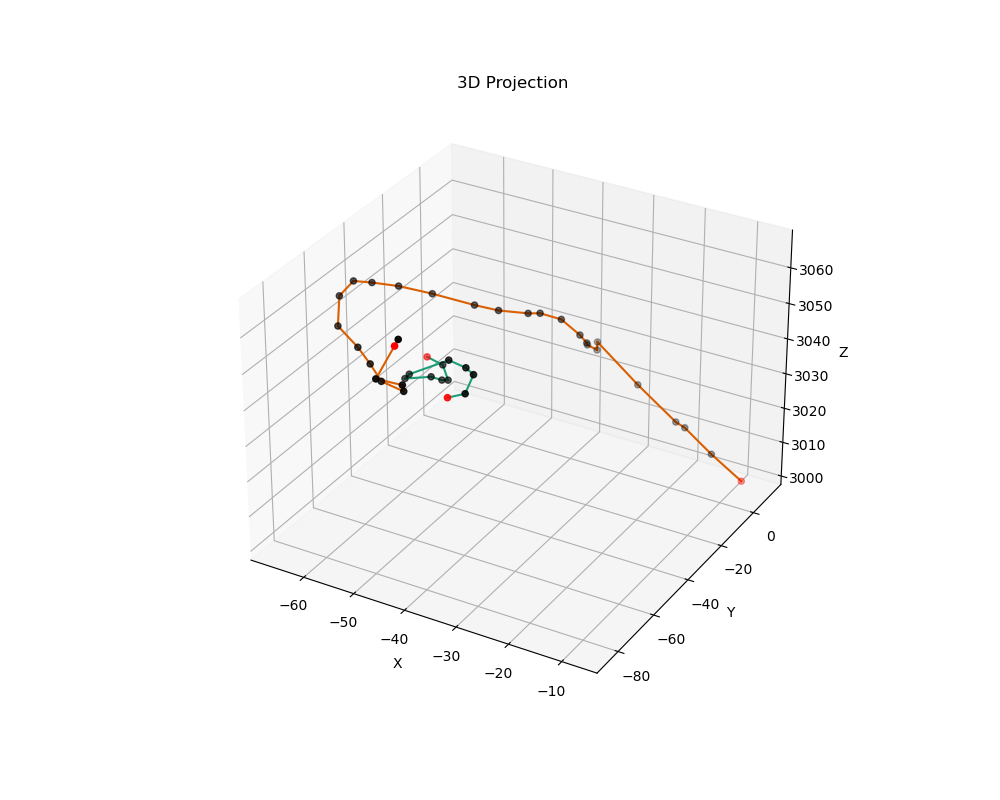

In [51]:
# Track building

def find_end_point(graph, start_node):
    visited = set()  # Set to keep track of visited nodes
    path = []  # List to keep track of the current path

    # Depth first search
    def dfs(node):
        visited.add(node)  # Mark the current node as visited
        path.append(node)  # Add the current node to the path

        # Check if the current node is an end-point (has only one neighbor and is not the starting node)
        if len(graph[node]) == 1 and node != start_node:
            return True  # End-point found, return True

        # Recursively visit all the neighbors
        for neighbor in graph[node]:
            if neighbor not in visited:  # Visit the neighbor if it hasn't been visited yet
                if dfs(neighbor):  # Continue the search with the neighbor
                    return True  # If an end-point is found, propagate the success signal

        path.pop()  # If no end-point is found along this path, backtrack
        return False  # Return False if no end-point is found

    dfs(start_node)  # Start the DFS from the start_node
    return path  # Return the track

def check_start_end_exists(number,Tracks):
    check_start = any(path["start"] == number for path in Tracks)
    check_end = any(path["end"] == number for path in Tracks)

    if (check_start or check_end):
        return True
    else:
        return False

# Function to calculate distance between two points
def calculate_distance(point1, point2):
    return np.sqrt((point2['x'] - point1['x'])**2 + (point2['y'] - point1['y'])**2 + (point2['z'] - point1['z'])**2)


def GetTrackLengthEnergy(path):
    total_length = 0
    total_energy = 0

    for t in range(len(path) - 1):
        point1 = data.iloc[path[t]]
        point2 = data.iloc[path[t + 1]]
        
        distance = calculate_distance(point1, point2)
        total_length += distance
        total_energy += point1['energy']
    
    # Add in the last energy hit
    total_energy += data.iloc[path[-1]]['energy']

    return round(total_length, 3), round(total_energy, 3)


colormap = plt.cm.get_cmap('Dark2')
color_cycle = itertools.cycle(colormap.colors)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

Tracks = []

for i,node in enumerate(single_nodes):
    
    if (check_start_end_exists(node,Tracks)):
        continue

    # Get the track path
    path = find_end_point(connected_nodes, node)

    total_length, total_energy = GetTrackLengthEnergy(path)
    color = next(color_cycle)

    Track = {"id":i, "start":path[0], "end":path[-1], "nodes":path, "length":total_length, "energy":total_energy,"label":"track","c":color}
    Tracks.append(Track)

print(Tracks)

# Plot the labeled track
# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
ax.scatter(data['x'], data['y'], data['z'], c=colors, marker='o')

for Track in Tracks:

    for i,connection in enumerate(Track["nodes"]):
            
            if (i == len(Track["nodes"])-1):
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i+1]
   
            ax.plot([data['x'][start_node], data['x'][end_node]],
                    [data['y'][start_node], data['y'][end_node]],
                    [data['z'][start_node], data['z'][end_node]], color=Track["c"],linestyle="-")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()



0
calling update connections
con_Nodes: [21, 11, 28]
[19, 21, 15, 18, 22] [19, 11, 7, 5, 2, 0, 1, 3, 4, 6, 13, 20, 24, 26, 32, 35, 34, 29, 30, 27, 36, 37, 38, 39, 40] [10, 12, 17, 16, 14, 8, 9, 23, 25, 31, 33, 28, 19]
0.084 0.15 0.174
Here
1
[{'id': 0, 'start': 19, 'end': 22, 'nodes': [19, 21, 15, 18, 22], 'length': 27.831, 'energy': 0.084, 'label': 'delta', 'c': 'darkred'}, {'id': 1, 'start': 10, 'end': 40, 'nodes': [10, 12, 17, 16, 14, 8, 9, 23, 25, 31, 33, 28, 19, 11, 7, 5, 2, 0, 1, 3, 4, 6, 13, 20, 24, 26, 32, 35, 34, 29, 30, 27, 36, 37, 38, 39, 40], 'length': 224.324, 'energy': 0.316, 'label': 'track', 'c': (0.4588235294117647, 0.4392156862745098, 0.7019607843137254)}]


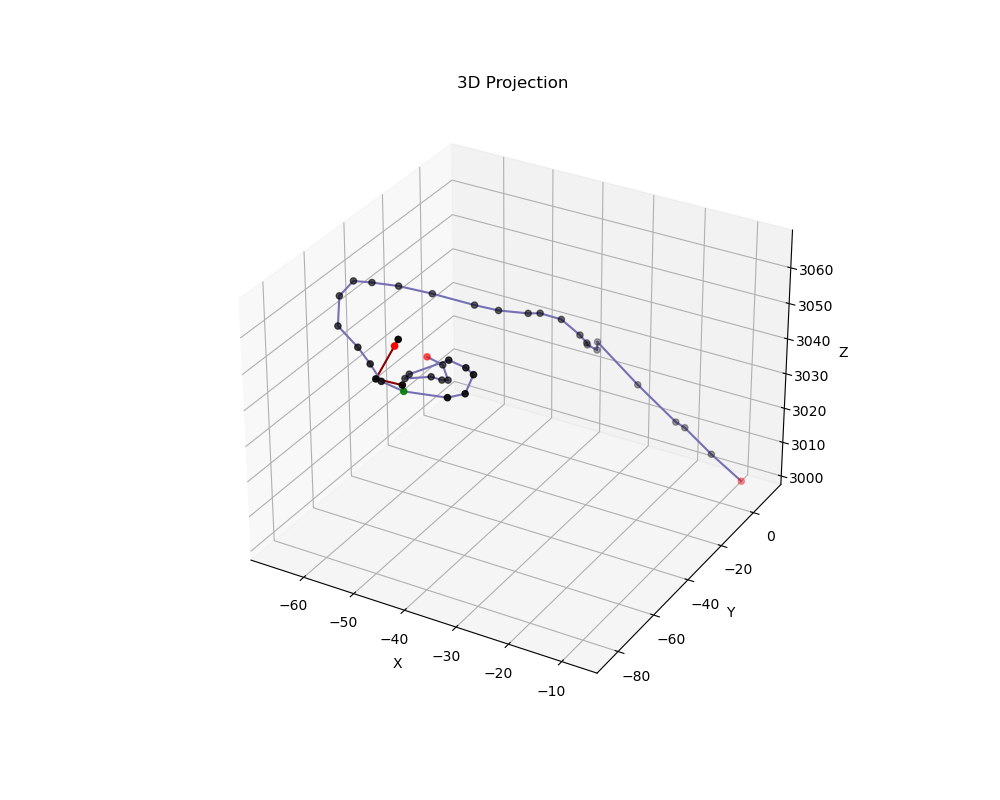

In [52]:
# Now look to merge tracks that are close by and identify deltas

def GetTrackwithNode(closest_idx):
    for t in Tracks:
        if (closest_idx in t["nodes"]):
            return t["id"]
    # The node wasnt found anywhere...
    return -1

def join_tracks(array1, array2):
    # Check if the arrays can be joined directly
    if array1[-1] == array2[0]:
        joined_array = array1 + array2[1:]
    elif array1[0] == array2[-1]:
        joined_array = array2 + array1[1:]
    # Check if reversing one of the arrays allows them to be joined
    elif array1[-1] == array2[-1]:
        array2_reversed = array2[::-1]
        joined_array = array1 + array2_reversed[1:]
    elif array1[0] == array2[0]:
        array1_reversed = array1[::-1]
        joined_array = array1_reversed + array2[1:]
    else:
        joined_array = array1 + array2  # If they can't be joined, just concatenate them

    return joined_array


def AddConnectedTracks(delta_path, delta_len, delta_e, seg1_path, seg2_path, UpdatedTracks):

    Delta = {"id":len(UpdatedTracks), "start":delta_path[0], "end":delta_path[-1], "nodes":delta_path, "length":delta_len, "energy":delta_e,"label":"delta","c":"darkred"}
    UpdatedTracks.append(Delta)
    
    joined_track_path = join_tracks(seg1_path, seg2_path)
    total_length_joined, total_energy_joined = GetTrackLengthEnergy(joined_track_path)
    color = next(color_cycle)
    
    Primary = {"id":len(UpdatedTracks), "start":joined_track_path[0], "end":joined_track_path[-1], "nodes":joined_track_path, "length":total_length_joined, "energy":total_energy_joined,"label":"track","c":color}
    UpdatedTracks.append(Primary)


UpdatedTracks = []

dist_threshold = 15

for Track in Tracks:
    print(Track["id"])
    start_node = Track["start"]
    end_node   = Track["end"]

    # dont run this if we only got one track!
    if (len(Tracks) == 1):
        UpdatedTracks.append(Track)
        break

    # Get the indexes of closest nodes to start and end
    dist_ind_start = np.argsort(dist_matrix[start_node])[1:]
    dist_ind_end   = np.argsort(dist_matrix[end_node])[1:]

    # Filter nodes that are in the current track
    dist_ind_start = [x for x in dist_ind_start if x not in Track["nodes"]]
    dist_ind_end   = [x for x in dist_ind_end if x not in Track["nodes"]]

    # Distances of the end point to the closest track
    dist_start = dist_matrix[start_node][dist_ind_start[0]]
    dist_end   = dist_matrix[end_node][dist_ind_end[0]]

    # apply threshold
    if (dist_start > dist_threshold and dist_end > dist_threshold):
        # UpdatedTracks.append(Track)
        continue

    closest_idx = 0
    end_conn_node = 0
    con_point = "start"
    curr_track_path = Track["nodes"]

    # Choose the smallest index
    if dist_start < dist_end:
        closest_idx = dist_ind_start[0]
        end_conn_node = start_node
        
    else:
        closest_idx = dist_ind_end[0]
        end_conn_node = end_node
        con_point = "end"

    # Check if the proposed connection will form a cycle
    # Temporarily add the connection to check for cycles
    temp_connections_dict = copy.deepcopy(connected_nodes)
    temp_connections      = copy.deepcopy(connections)
    temp_connection_count = copy.deepcopy(connection_count)

    UpdateConnections(end_conn_node, closest_idx, temp_connections_dict, temp_connections, temp_connection_count)

    # Check for cycles
    cycle = forms_cycle(end_conn_node, closest_idx, temp_connections_dict)

    temp_connections_dict = {}
    temp_connections = []
    temp_connection_count = []
    
    if not cycle:

        if (con_point =="start"):
            curr_track_path.insert(0,closest_idx)
        else:
            curr_track_path.append(closest_idx)

        Track["nodes"] = curr_track_path
        UpdateConnections(closest_idx, end_conn_node, connected_nodes, connections, connection_count)
    else:
        break


    # Get the track ID where the connecting node is located
    trk_id = GetTrackwithNode(closest_idx)

    # Get the length either side of track
    print("con_Nodes:",connected_nodes[closest_idx])
    seg1_path = find_end_point(connected_nodes, connected_nodes[closest_idx][0])
    seg2_path = find_end_point(connected_nodes, connected_nodes[closest_idx][1])

    seg1_path.insert(0,closest_idx)
    seg2_path.insert(0,closest_idx)

    # Now get the lengths and energies of the track segments
    total_length_seg1, total_energy_seg1 = GetTrackLengthEnergy(seg1_path)
    total_length_seg2, total_energy_seg2 = GetTrackLengthEnergy(seg2_path) 
    total_length_seg3, total_energy_seg3 = GetTrackLengthEnergy(curr_track_path) 

    print(seg1_path,seg2_path,curr_track_path)
    print(total_energy_seg1,total_energy_seg2,total_energy_seg3)

    # Find the delta and the primary track and add them to the new track list
    if (total_energy_seg1 < total_energy_seg2 and total_energy_seg1 < total_energy_seg3):
        AddConnectedTracks(seg1_path, total_length_seg1, total_energy_seg1, seg2_path, curr_track_path, UpdatedTracks)
    
    elif ((total_energy_seg2 < total_energy_seg1 and total_energy_seg2 < total_energy_seg3)):
        AddConnectedTracks(seg2_path, total_length_seg2, total_energy_seg2, seg1_path, curr_track_path, UpdatedTracks)
    
    else:
        Delta = {"id":len(UpdatedTracks), "start":curr_track_path[0], "end":curr_track_path[-1], "nodes":curr_track_path, "length":total_length_seg3, "energy":total_energy_seg3,"label":"delta","c":"darkred"}
        UpdatedTracks.append(Delta)

print(UpdatedTracks)

# Plot the labeled track
# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['r' if count == 1 or count == 0 else 'g' if count == 3 else 'k' for count in connection_count]
ax.scatter(data['x'], data['y'], data['z'], c=colors, marker='o')

for Track in UpdatedTracks:

    for i,connection in enumerate(Track["nodes"]):
            
            if (i == len(Track["nodes"])-1):
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i+1]
   
            ax.plot([data['x'][start_node], data['x'][end_node]],
                    [data['y'][start_node], data['y'][end_node]],
                    [data['z'][start_node], data['z'][end_node]], color=Track["c"],linestyle="-")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()

